# From Prompts to Workflows

In this notebook, we'll see why a single LLM prompt breaks down on multi-step tasks and how LangGraph provides **structure, state, and control flow** to fix it.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
# Expects: OPENROUTER_API_KEY, SERPAPI_API_KEY
# Optional: LANGSMITH_API_KEY

True

In [2]:
from langchain_openai import ChatOpenAI

# We use OpenRouter as our LLM gateway — swap models by changing the model string
llm = ChatOpenAI(
    model="openai/gpt-4.1-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

/Users/sinanozdemir/Teaching/Pearson/oreilly-langgraph/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Why single prompts break down

Let's try asking a model to do three things in one shot:
1. Write a product description for a fictional AI tool
2. Critique the description for clarity, tone, and persuasiveness
3. Rewrite an improved version based on the critique

This is a common pattern — you want a pipeline of steps, but you cram it all into one prompt.

In [3]:
# One prompt trying to do three things at once
response = llm.invoke(
    "Write a product description for a fictional AI-powered meeting assistant called 'MeetingMind'. "
    "Then critique the description for clarity, tone, and persuasiveness. "
    "Then rewrite an improved version based on the critique."
)
print(response.content)

**Original Product Description:**

Meet MeetingMind, your AI-powered meeting assistant designed to revolutionize the way you conduct meetings. MeetingMind listens, analyzes, and synthesizes every discussion point, automatically generating detailed minutes, action items, and follow-up reminders. Powered by cutting-edge natural language processing, MeetingMind ensures no important detail slips through the cracks. With seamless integration into your favorite calendar and communication apps, it transforms chaotic meetings into productive sessions, saving you hours each week. Say goodbye to note-taking stress and hello to smarter, more efficient meetings with MeetingMind.

---

**Critique:**

- **Clarity:** The description clearly explains what MeetingMind does and how it benefits the user. Terms like "natural language processing" might be slightly technical for a general audience, but it adds credibility without overwhelming the text.

- **Tone:** The tone is professional yet approachable,

Notice how the model tries to do everything in one pass. The "critique" is shallow because the model already committed to the description and doesn't want to contradict itself. The "rewrite" barely changes anything.

This *kind of* works for simple tasks, but the model has no way to:
- **Separate generation from evaluation** — it critiques its own work in the same breath
- **Actually improve** — the critique and rewrite are performative, not substantive
- **Debug** — if the final copy is bad, which step failed?

For anything beyond toy examples, we need **structure**.

## LangGraph: Graphs as a better abstraction

LangGraph models workflows as **directed graphs**:
- **Nodes** = individual processing steps (each does one focused thing)
- **Edges** = connections that pass state between steps
- **State** = a typed dictionary that carries context through the graph

Let's rebuild the same task as a 3-node graph.

## Side-by-side comparison

In [4]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class WorkflowState(TypedDict):
    product_name: str
    draft: str
    critique: str
    final_copy: str


def generate_node(state: WorkflowState) -> dict:
    """Step 1: Write an initial product description."""
    response = llm.invoke(
        f"Write a compelling product description (2-3 paragraphs) for a fictional "
        f"AI-powered tool called '{state['product_name']}'. "
        f"It's an AI meeting assistant that joins video calls, takes notes, "
        f"identifies action items, and sends follow-up summaries."
    )
    return {"draft": response.content}


def critique_node(state: WorkflowState) -> dict:
    """Step 2: Critically evaluate the draft — separate LLM call, fresh perspective."""
    response = llm.invoke(
        f"You are a senior copywriter reviewing a junior writer's work. "
        f"Critique this product description for:\n"
        f"- **Clarity**: Is it easy to understand? Any jargon or vague claims?\n"
        f"- **Tone**: Is it professional yet engaging? Too salesy or too flat?\n"
        f"- **Persuasiveness**: Does it make you want to try the product? What's missing?\n\n"
        f"Be specific and constructive. Point to exact phrases that need improvement.\n\n"
        f"Product description:\n{state['draft']}"
    )
    return {"critique": response.content}


def refine_node(state: WorkflowState) -> dict:
    """Step 3: Rewrite the description incorporating the critique."""
    response = llm.invoke(
        f"Rewrite this product description, addressing every point in the critique below. "
        f"Keep what works, fix what doesn't.\n\n"
        f"Original draft:\n{state['draft']}\n\n"
        f"Critique:\n{state['critique']}\n\n"
        f"Rewritten description:"
    )
    return {"final_copy": response.content}


# Build the graph
graph = StateGraph(WorkflowState)
graph.add_node("generate", generate_node)
graph.add_node("critique", critique_node)
graph.add_node("refine", refine_node)

graph.add_edge(START, "generate")
graph.add_edge("generate", "critique")
graph.add_edge("critique", "refine")
graph.add_edge("refine", END)

app = graph.compile()

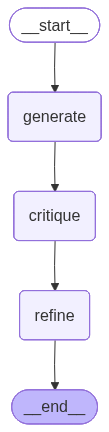

In [5]:
# Visualize the graph topology
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
# Run it
result = app.invoke({"product_name": "MeetingMind"})

print("=== Draft ===")
print(result["draft"])
print("\n=== Critique ===")
print(result["critique"])
print("\n=== Final Copy ===")
print(result["final_copy"])

=== Draft ===
Meet MeetingMind, your ultimate AI-powered meeting assistant designed to transform the way you collaborate and stay organized. Seamlessly integrating with your video calls, MeetingMind joins your meetings in real-time, expertly capturing every detail while you focus on the conversation. It listens attentively, taking comprehensive notes that highlight key points and track important decisions without missing a beat. Whether you're brainstorming, strategizing, or conducting team check-ins, MeetingMind ensures every crucial insight is documented accurately and effortlessly.

But MeetingMind doesn't stop at note-taking—it's your proactive partner in driving productivity forward. Using advanced AI, it identifies action items and assigns clear next steps, helping teams stay aligned and accountable. After the meeting ends, MeetingMind compiles a concise, easy-to-digest summary and instantly sends it to all participants, eliminating the need for tedious manual follow-ups. With Me